<a href="https://colab.research.google.com/github/KevinSarmiento/Personal/blob/master/data_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import math

In [ ]:
# New version of Get Data by date function 

def get_data_by_dates(path, dates, extension='.tsv'):
  """Extracts all data over one or more ProCoDA data files based on date. Valid
    only for files whose names are automatically generated by date, i.e. of the 
    form "datalog_M-D-YYYY".

    :param path: The path to the folder containing the ProCoDA data file(s)
    :type path: string
    :param dates: A single date or list of dates ordered in the way data was collected, formatted "M-D-YYYY"
    :type dates: string or string list
    :param extension: File extension of the data file(s). Defaults to '.tsv'
    :type extension: string, optional
    :return: A DataFrame of the continious data from one or more ProCoDA data files
    :rtype: DataFrame """

  data = ac.data_from_dates(path, dates, extension) #notes are removed in here

  if isinstance(dates, str):
    # notes = ac.notes(path)
    return data
  else:
    result = merge_raw_data(data, ignore_index=True, sort=False)
  return result
    
def merge_raw_data(data,notes=False,ignore_index=True, sort=False,**kwargs):
  """
  data arg: a list of data to merge 
  """
  master_df = data[0]
  note_index=list(master_df.index)
  if notes == False:
    master_df.iloc[:,0]= master_df.iloc[:,0].apply(lambda x: float(x))
    column_align = master_df.columns[0]
  else: 
    master_df = master_df.rename(columns={master_df.columns[0]: 'Note',master_df.columns[1]:'Data Index'})
    column_align = master_df.columns[1]
  for i in range(1,len(data)): 
    if notes == False:
      # I have to rename the first column because ProCoDA automatically changes the name of this column after 11:59PM 
      data[i].rename(columns={data[i].columns[0]: column_align}, inplace = True)
      # ProCoDA data file contains strings and not floats so I need to change that for the first column
      data[i].iloc[:,0]= data[i].iloc[:,0].apply(lambda x: float(x))
      # I add i to the day fraction since we assume the run was continuous
      data[i].iloc[:,0] = data[i].iloc[:,0].apply(lambda x: x + i)
    else:
      note_index.extend(list(data[i].index))
      data[i].rename(columns={data[i].columns[0]: column_align}, inplace = True)
      data[i] = data[i].rename(columns={data[i].columns[0]: 'Note',data[i].columns[1]:'Data Index'})
    master_df = master_df.append(data[i], ignore_index=True, sort=False,**kwargs)
  if notes == False: 
    return master_df
  else:
    master_df[data[i].columns[1]] = note_index
    return master_df

In [ ]:
def get_data_by_time(data, columns, dates, start_time='00:00', end_time='23:59',
                     extension='.tsv', units=""):
    """Extract columns of data over one or more ProCoDA data files based on date
    and time. Valid only for files whose names are automatically generated by
    date, i.e. of the form "datalog_M-D-YYYY".
    Note: Column 0 is time. The first data column is column 1.
    :param path: The path to the folder containing the ProCoDA data file(s)
    :type path: string
    :param columns: A single column index or a list of column indexes
    :type columns: int or int list
    :param dates: A single date or list of dates, formatted "M-D-YYYY"
    :type dates: string or string list
    :param start_time: Starting time of data to extract, formatted 'HH:MM' (24-hour time)
    :type start_time: string, optional
    :param end_time: Ending time of data to extract, formatted 'HH:MM' (24-hour time)
    :type end_time: string, optional
    :param extension: File extension of the data file(s). Defaults to '.tsv'
    :type extension: string, optional
    :param units: The units you want to apply to the data, e.g. 'mg/L'. Defaults to "" (dimensionless).
    :type units: string, optional
    :return: the single column of data or a list of the columns of data (in the order of the indexes given in the columns variable)
    :rtype: 1D or 2D float list
    :Examples:
    .. code-block:: python
        data = get_data_by_time(path='/Users/.../ProCoDA Data/', columns=4, dates=['6-14-2018', '6-15-2018'], start_time='12:20', end_time='10:50')
        data = get_data_by_time(path='/Users/.../ProCoDA Data/', columns=[0,4], dates='6-14-2018', start_time='12:20', end_time='23:59')
        data = get_data_by_time(path='/Users/.../ProCoDA Data/', columns=[0,3,4], dates='6-14-2018')
    """

    column_name_list=list(data.columns)
    new_columns = []
    for index in columns:
      new_columns.append(column_name_list[index])
    new_df = data[new_columns].copy()

    first_time_column = pd.to_numeric(data.iloc[:, 0])
    start = max(ac.day_fraction(start_time), first_time_column[0])
    print('start time',start)
    start_idx = find_index(start, data)
    print('start index',start_idx)
    end_time_fraction = ac.day_fraction(end_time)+ len(dates)-1
    finish = min(end_time_fraction,first_time_column[len(data)-1] ) 
    print ('end time' ,finish)
    end_idx = (find_index(finish ,data))-1
    print('end index',end_idx)

    return new_df.iloc[start_idx:end_idx,:]

def find_index(time, data, abs_tol=0.0001):
  """
  
  """
  for i in range(len(data.iloc[:,0])):
    if math.isclose(time,data.iloc[i,0],abs_tol=abs_tol) == True:
      return i
  return None

In [ ]:
def find_index_2(time, data, rel_tol=0.01):
  """
  
  """
  for i in range(len(data.iloc[:,0])):
    if math.isclose(time,data.iloc[i,0],rel_tol=rel_tol) == True:
      return i
  return None

def plot_data(data,columns,time_span,height_changes=[],steady_state=[],PC12_sample=[],AVG_data= False ,**kwargs):
  if AVG_data == True:
    index_start_time = find_index_2(time_span[0], data)
  else:
    index_start_time = find_index(time_span[0], data)
  time_zero = data.iloc[index_start_time,0]
  time_elapsed = []
  time_interval = 24
  for time in data.iloc[:,0]:
    time_hours_elapsed = (time *time_interval)- (time_zero *time_interval)
    time_elapsed.append(time_hours_elapsed)
  data['Time Elapsed (Hours)']=time_elapsed
  xlim_max = (time_span[1]-time_span[0])*time_interval
  fig, ax = plt.subplots()
  data.plot(x='Time Elapsed (Hours)',y= columns,xlim=[0,xlim_max],ax=ax ,**kwargs)
  if height_changes != []:
    for day_frac in height_changes:
      time_hours_elapsed = (day_frac *time_interval)- (time_zero *time_interval)
      plt.axvline(x=time_hours_elapsed, ymin=0, ymax=10**3,color='purple',dashes=(5, 5,5,5 ))
  if steady_state != []:
    for day_frac in steady_state:
      time_hours_elapsed = (day_frac *time_interval)- (time_zero *time_interval)
      plt.axvline(x=time_hours_elapsed, ymin=0, ymax=10**3,color='red',dashes=(5, 5,5,5 ))
  if PC12_sample != []:
    for day_frac in PC12_sample:
      time_hours_elapsed = (day_frac *time_interval)- (time_zero *time_interval)
      plt.axvline(x=time_hours_elapsed, ymin=0, ymax=10**3,color='black',dashes=(5, 5,5,5 ))
  ax.legend(loc="lower center",bbox_to_anchor=(1.2, 0.5), ncol= 1) # legend goes outside with this
  ax.grid()



In [ ]:
def data_averaging(data, columns, group_size):
  """
  Function groups rows in each specified column in a DataFrame and averages that grouping 
  and returns a new averaged DataFrame

  :param data: data set to average 
  :type path: Pandas DataFrame 

  :param columns: columns of the DataFrame to average
  :type columns: list

  :param group_size: The number of rows to average to a singular value 
  :type group_size: int

  """
  new_df_columns = []
  new_df_column_names_1 = []
  df_list = []
  for column in columns:
    avg_value = list(map(np.mean,[data.iloc[i:i+group_size,column] for i in range(0,len(data)-group_size+1,group_size)]))
    # new_df_columns.append(avg_value)
    new_df_column_names = data.columns[column]
    new_df_column_names_1.append(new_df_column_names)
    new_df = pd.DataFrame(avg_value)
    df_list.append(new_df)
  new_df = pd.concat(df_list, axis = 1,ignore_index=True)
  new_df.columns = new_df_column_names_1
  return new_df


In [ ]:
# Edited on 11/15
def data_cleaner_UV(data,columns,time_span):
  start_index= find_index(time_span[0], data)
  stop_index = find_index(time_span[1], data)
  data_copy= data.copy(deep=True)
  for column in range(len(data_copy.columns)):
    print(column)
    if column in columns:
      print('True')
      end = min(stop_index,len(data_copy)+1)
      for row in range(start_index,stop_index):
        current_value = data.iloc[row,column]
        if current_value is None:
          print('value is none')
        prev_average = data_copy.iloc[row-20:row-1,column].mean()
        error = (abs(current_value - prev_average)/(prev_average))*100
        if current_value > 10 or current_value < 10**-5:
          #error > 99.999
          data_copy.iloc[row,column] =  prev_average
        else:
          None 
  return data_copy

def data_cleaner_PC(data,columns,time_span):
  start_index= find_index(time_span[0], data)
  stop_index = find_index(time_span[1], data)
  data_copy= data.copy(deep=True)
  column_headers = ['2-3 μm','3-5 μm','5-9 μm','9-17 μm', '17-33 μm', '33-65 μm','Total Count']
  count = 0
  for column in range(len(data_copy.columns)):
    print(column)
    if column in columns:
      print('True')
      data_copy.rename(columns = {data.columns[column]: column_headers[count]},inplace = True)
      count+= 1
      end = min(stop_index,len(data_copy)+1)
      for row in range(start_index,stop_index):
        current_value = data.iloc[row,column]
        if current_value is None:
          print('value is none')
        prev_average = np.mean(data_copy.iloc[row:row+5,column])
        if prev_average == 0:
          prev_average = 0.5
        error = ((current_value - prev_average)/(prev_average))*100
        if current_value != 0 and (error > 9 or error < -.9):
          #current_value > 10**2.5 or current_value < 10**-2
          data_copy.iloc[row,column] =  None
        else:
          None 
  return data_copy
# (current_value != 0 and current_value <= 0.00000999) or


[2113.478260869565, 954.2477876106195, 762.0438596491229, 327.9339622641509, 78.8586956521739, 19.658227848101266, 1.9836591060833337]
2-3 μm
2113.478260869565
3-5 μm
954.2477876106195
5-9 μm
762.0438596491229
9-17 μm
327.9339622641509
17-33 μm
78.8586956521739
33-65 μm
19.658227848101266
Turb settled w/ blanket ()
1.9836591060833337
0.7836


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


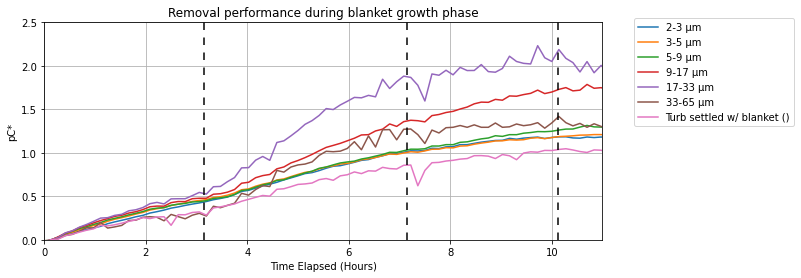

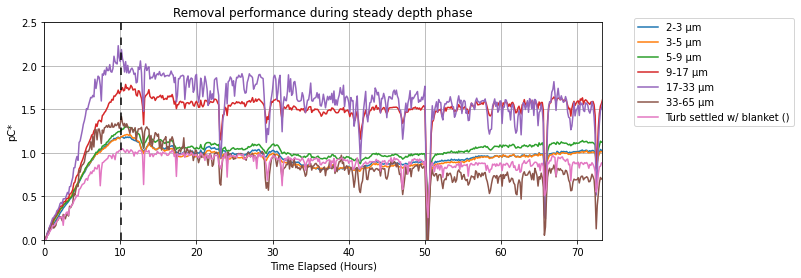

In [ ]:
def initial_values(data,columns,time_after_start):

  start = [time_span[0] + ((time_after_start*60)/86400)]
  start_end_list = []

  for time in start:
    five_min = (5*60)/ 86400
    start_end_list.append([time - five_min, time + five_min])
  mean_initial_count = list(np.mean(data.iloc[ find_index(start_end_list[0][0], data) : find_index(start_end_list[0][1], data) , columns ]))
  
  return mean_initial_count


In [ ]:
def PSD_grapher(data, times, columns, bin_intervals):
  """
  Function groups rows in each specified column in a DataFrame and averages that grouping 
  and returns a new averaged DataFrame

  :param data: data set to average 
  :type path: Pandas DataFrame 

  :param columns: columns of the DataFrame to average
  :type columns: list

  :param group_size: The number of rows to average to a singular value 
  :type group_size: int

  """
  bin_size = []
  delta_diam_bin=[]
  for i in bin_intervals:
    bin_size.append(np.mean(i))
    delta_diam_bin.append((i[1] - i[0]))
  column_1 = 'Bin size (μm)'
  df = pd.DataFrame(bin_size, columns = [column_1])
  column_2 = 'delta diam'
  df[column_2]= delta_diam_bin
  time_zero = times[0]
  time_interval = 24
  for time in times:
    five_min = (5*60)/ 86400
    start_end_list = [time - five_min, time + five_min]
    mean_initial_count = list(np.mean(data.iloc[ find_index(start_end_list[0], data) : find_index(start_end_list[1], data) , columns ]))
    time_hours_elapsed = (time *time_interval)- (time_zero *time_interval)
    df[str(round(time_hours_elapsed,1))+' hours'] = mean_initial_count

  df[column_1] =df[column_1].apply(lambda x: np.log10(x)) 
  bin_list = df[column_1]
  
  df[:] = df[:].apply(lambda row: np.log10( row /row[column_2] ) , axis =1)
  df[column_1] = bin_list
  
  return df